In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
path = Path.cwd()
datapath = path / 'spectroscopydata'
outputpath = path / 'spectroscopyresults'

In [3]:
u = 1.6605 * 1e-27
m85 = 84.91 * u	
m87 = 86.91 * u	 
c = 299792458
kB = 1.380649 * 1e-23

In [4]:
def lorentzian(x,A,mean,gamma):
    return A/(1+4*(x-mean)**2/gamma**2)

def shifted_lorentzian(x,A,mean,gamma,offset):
    return lorentzian(x,A,mean,gamma)+offset

def gaussian(x,A,mean,std):
    return -A/np.sqrt(2*np.pi*std**2)*np.exp(-0.5*(x-mean)**2/std**2)

def shifted_gaussian(x,A,mean,std,offset,slope):
    return gaussian(x,A,mean,std)+offset+slope*x

def global_gaussian(x,A1,A2,A3,A4,mean1,mean2,mean3,mean4,std1,std2,std3,std4,offset,slope):
    return gaussian(x,A1,mean1,std1)+gaussian(x,A2,mean2,std2)+gaussian(x,A3,mean3,std3)+gaussian(x,A4,mean4,std4)+offset+slope*x

In [5]:
def set_mask(x,boundl,boundr):
    mask = np.logical_and(boundl < x, x < boundr)
    return mask
    
def interpolate_zero_between(x,y,idl,idr):
    a = y[idl]
    b = (y[idr]-y[idl])/(x[idr]-x[idl])
    return -a/b+x[idl]

# Global Scan & Calibration

In [65]:
data = pd.read_csv(datapath/'DigiLock-ScopeData.txt', sep="\t")
data_nr = pd.read_csv(datapath/'DigiLock-ScopeData_norepump.txt', sep = "\t")
timebase = 50 * 1e-3
divisions = 4
timeaxis = np.linspace(0,divisions*timebase,len(data_nr['Aux out [V]']))

Text(0.5, 1.0, 'Repump off')

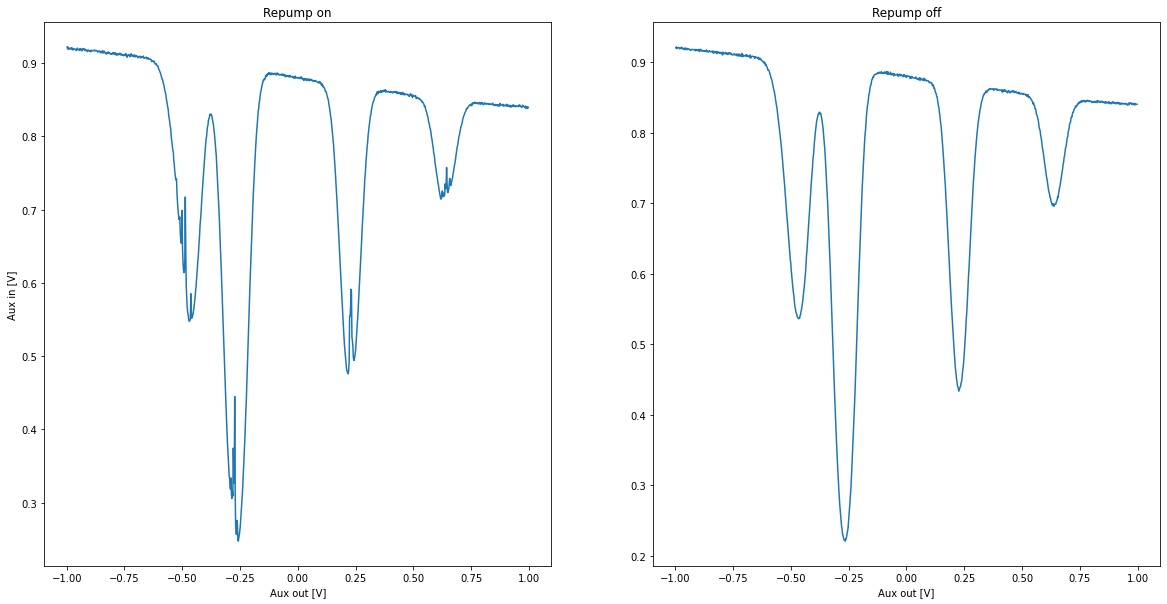

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [67]:
popt, pcov = curve_fit(global_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0,0,0,-0.7,-0.4,0.1,0.5,0,0,0,0,0,-0.2],[1,1,1,1,-0.3,0,0.4,0.75,0.5,0.5,0.5,0.5,1,0]))
perr = np.sqrt(np.diag(pcov))

res = 0.211513
A1 = 0.04262 +/- 0.000172, mean1 = -0.47112 +/- 0.000192 ,std1 = 0.04656 +/- 0.000202
A2 = 0.07965 +/- 0.000166, mean2 = -0.26739 +/- 0.000100 ,std2 = 0.04583 +/- 0.000105
A3 = 0.04482 +/- 0.000155, mean3 = 0.22801 +/- 0.000147 ,std3 = 0.04066 +/- 0.000152
A4 = 0.01618 +/- 0.000166, mean4 = 0.63781 +/- 0.000415 ,std4 = 0.04124 +/- 0.000441
offset = 0.88000 +/- 0.000285, slope = -0.04186 +/- 0.000428


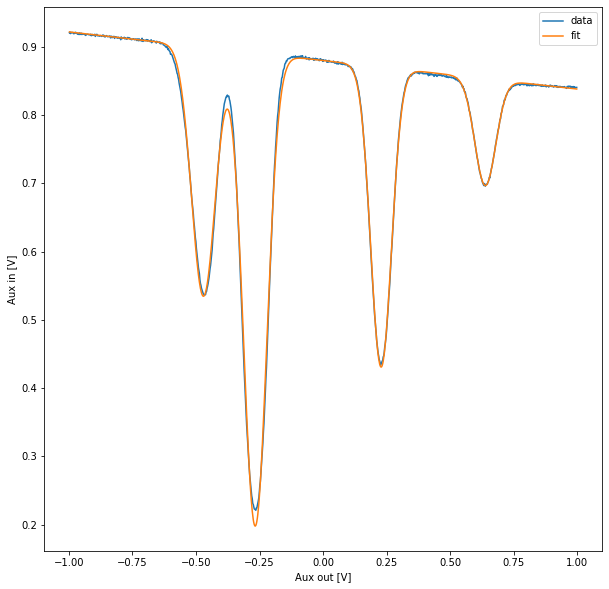

In [68]:
plt.figure(figsize = (10,10))
plt.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
plt.plot(data_nr['Aux out [V]'], global_gaussian(data_nr['Aux out [V]'],*popt),label='fit')
#plt.plot(data_nr['Aux out [V]'],popt[-1]*data_nr['Aux out [V]']+popt[-2])
plt.xlabel('Aux out [V]')
plt.ylabel('Aux in [V]')
plt.legend()
print("res = {:f}".format(np.sqrt(np.sum((global_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
for i in range(0,4):
    print("A{:d} = {:.5f} +/- {:5f}, mean{:d} = {:.5f} +/- {:5f} ,std{:d} = {:.5f} +/- {:5f}".format(i+1,popt[i],perr[i],i+1,popt[i+4],perr[i+4],i+1,popt[i+8],perr[i+8]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))

In [69]:
print("Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.")
delta_t = (popt[7]-popt[4])
delta_t_err = np.sqrt(perr[7]**2+perr[4]**2)
print("Time difference: ({:f} +/- {:f}) s".format(delta_t,delta_t_err))
print("Literaturwert: 6.834682 GHz")
K = 6.834682/delta_t
K_err = 6.834682/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) GHz/V".format(K,K_err))

Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.
Time difference: (1.108934 +/- 0.000457) s
Literaturwert: 6.834682 GHz
Kalibrierungsfaktor K = (6.163 +/- 0.003) GHz/V


In [70]:
print("Frequenzabstand 85Rb F=3 -> F':")
dt = (popt[5]-popt[4])
dt_err = np.sqrt(perr[5]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 1.298 GHz")
print("rel. Abweichung: {:.2f}%".format((f-1.298)/1.298*100))

Frequenzabstand 85Rb F=3 -> F':
Messung: (1.2557 +/- 0.0014) GHz
Theorie: 1.298 GHz
rel. Abweichung: -3.26%


In [71]:
print("Frequenzabstand 85Rb F=2 -> F':")
dt = (popt[6]-popt[4])
dt_err = np.sqrt(perr[6]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 4.33 GHz")
print("rel. Abweichung: {:.2f}%".format((f-4.33)/4.33*100))

Frequenzabstand 85Rb F=2 -> F':
Messung: (4.3089 +/- 0.0023) GHz
Theorie: 4.33 GHz
rel. Abweichung: -0.49%


In [78]:
print("Dopplerverbreiterung:")
sigma_V1 = popt[8]
sigma_V1_err = perr[8]
sigma_V2 = popt[9]
sigma_V2_err = perr[9]
sigma_V3 = popt[10]
sigma_V3_err = perr[10]
sigma_V4 = popt[11]
sigma_V4_err = perr[11]

sigma1 = K * sigma_V1 *1e3 #MHz
sigma1_err = np.sqrt((sigma_V1*K_err)**2+(K*sigma_V1_err)**2) *1e3 #MHz
sigma2 = K * sigma_V2 *1e3 #MHz
sigma2_err = np.sqrt((sigma_V2*K_err)**2+(K*sigma_V2_err)**2) *1e3 #MHz
sigma3 = K * sigma_V3 *1e3 #MHz
sigma3_err = np.sqrt((sigma_V3*K_err)**2+(K*sigma_V3_err)**2) *1e3 #MHz
sigma4 = K * sigma_V4 *1e3 #MHz
sigma4_err = np.sqrt((sigma_V4*K_err)**2+(K*sigma_V4_err)**2) *1e3 #MHz


mean1 = 384.2304844685 * 1e6 - 2.563005979089109 *1e3 #MHz
mean1_err = np.sqrt((0.0000000062 * 1e6)**2 + (0.000000000000034 * 1e3)**2) #MHz
mean2 = 384.230406373 * 1e6 - 1.2648885163 *1e3 #MHz
mean2_err = np.sqrt((0.000000014 * 1e6)**2 + (0.000000000025 * 1e3)**2) #MHz
mean3 = 384.230406373 * 1e6 + 1.7708439228 *1e3 #MHz
mean3_err = np.sqrt((0.000000014 * 1e6)**2 + (0.0000000035 * 1e3)**2) #MHz
mean4 = 384.2304844685 * 1e6 + 4.271676631815181 *1e3 #MHz
mean4_err = np.sqrt((0.0000000062 * 1e6)**2 + (0.000000000000056 * 1e3)**2) #MHz



T1 = (sigma1/mean1)**2 * m87*c**2/kB
T1_err = np.sqrt((2*sigma1/mean1**2 * sigma1_err)**2+(2*sigma1**2/mean1**3 * mean1_err)**2) * m87*c**2/kB
T2 = (sigma2/mean2)**2 * m85*c**2/kB
T2_err = np.sqrt((2*sigma2/mean2**2 * sigma2_err)**2+(2*sigma2**2/mean2**3 * mean2_err)**2) * m85*c**2/kB
T3 = (sigma3/mean3)**2 * m85*c**2/kB
T3_err = np.sqrt((2*sigma3/mean3**2 * sigma3_err)**2+(2*sigma3**2/mean3**3 * mean3_err)**2) * m85*c**2/kB
T4 = (sigma4/mean4)**2 * m87*c**2/kB
T4_err = np.sqrt((2*sigma4/mean4**2 * sigma4_err)**2+(2*sigma4**2/mean4**3 * mean4_err)**2) * m87*c**2/kB


print("Temperatur aus 87 F=2 -> F': ({:.1f} +/- {:.1f}) K".format(T1,T1_err))
print("Temperatur aus 85 F=3 -> F': ({:.1f} +/- {:.1f}) K".format(T2,T2_err))
print("Temperatur aus 85 F=2 -> F': ({:.1f} +/- {:.1f}) K".format(T3,T3_err))
print("Temperatur aus 87 F=1 -> F': ({:.1f} +/- {:.1f}) K".format(T4,T4_err))

Dopplerverbreiterung:
Temperatur aus 87 F=2 -> F': (524.0 +/- 4.6) K
Temperatur aus 85 F=3 -> F': (496.0 +/- 2.3) K
Temperatur aus 85 F=2 -> F': (390.4 +/- 2.9) K
Temperatur aus 87 F=1 -> F': (411.0 +/- 8.8) K


# Natürliche Linienbreite (& Hyperfeinaufspaltung)

## 87 Rb F=2 --> F'

Text(0.5, 1.0, 'Repump off')

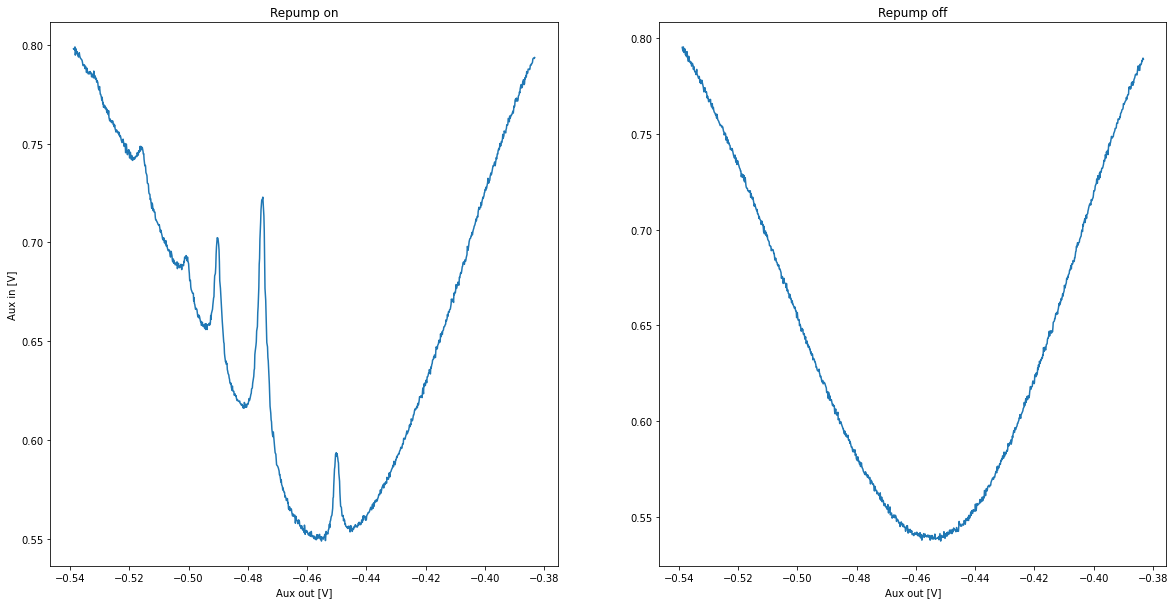

In [34]:
transition = "87_2"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [35]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,-0.5,0,0,-1],[1,-0.4,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))
data_substracted = data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt)

In [36]:
mask1 = set_mask(data['Aux out [V]'],-0.536,-0.526)
popt1, pcov1 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask1],data_substracted[mask1],bounds=([0,-0.536,0,0],[1,-0.526,0.5,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],-0.525,-0.505)
popt2, pcov2 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask2],data_substracted[mask2],bounds=([0,-0.525,0,0],[1,-0.505,0.5,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],-0.505,-0.495)
popt3, pcov3 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask3],data_substracted[mask3],bounds=([0,-0.505,0,0],[1,-0.49,0.5,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],-0.495,-0.485)
popt4, pcov4 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask4],data_substracted[mask4],bounds=([0,-0.5,0,0],[1,-0.48,0.5,1]))
perr4 = np.sqrt(np.diag(pcov4))

mask5 = np.logical_and(-0.48 < data['Aux out [V]'], data['Aux out [V]'] < -0.46)
popt5, pcov5 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask5],data_substracted[mask5],bounds=([0,-0.48,0,0],[1,-0.46,0.5,1]))
perr5 = np.sqrt(np.diag(pcov5))

mask6 = set_mask(data['Aux out [V]'],-0.455,-0.445)
popt6, pcov6 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask6],data_substracted[mask6],bounds=([0,-0.46,0,0],[1,-0.44,0.5,1]))
perr6 = np.sqrt(np.diag(pcov6))

Gaussian:
res = 0.047531
A = 0.04663 +/- 0.000219, mean = -0.45253 +/- 0.000050 ,std = 0.05012 +/- 0.000106
offset = 1.08475 +/- 0.002729, slope = 0.38466 +/- 0.004309

Lorentzian 1:
res = 0.007330
A = 0.00604 +/- 0.000408, mean = -0.53139 +/- 0.000088 ,gamma = 0.00317 +/- 0.000464, offset = 0.00469 +/- 0.000357

Lorentzian 2:
res = 0.025006
A = 0.02005 +/- 0.000805, mean = -0.51554 +/- 0.000063 ,gamma = 0.00319 +/- 0.000238, offset = 0.00951 +/- 0.000341

Lorentzian 3:
res = 0.016445
A = 0.01723 +/- 0.000911, mean = -0.50044 +/- 0.000062 ,gamma = 0.00255 +/- 0.000283, offset = 0.01772 +/- 0.000638

Lorentzian 4:
res = 0.014183
A = 0.06419 +/- 0.000779, mean = -0.49012 +/- 0.000014 ,gamma = 0.00257 +/- 0.000066, offset = 0.02177 +/- 0.000542

Lorentzian 5:
res = 0.039573
A = 0.13829 +/- 0.001186, mean = -0.47517 +/- 0.000016 ,gamma = 0.00377 +/- 0.000058, offset = 0.01380 +/- 0.000517

Lorentzian 6:
res = 0.011398
A = 0.04688 +/- 0.000649, mean = -0.45007 +/- 0.000015 ,gamma = 0.00234 

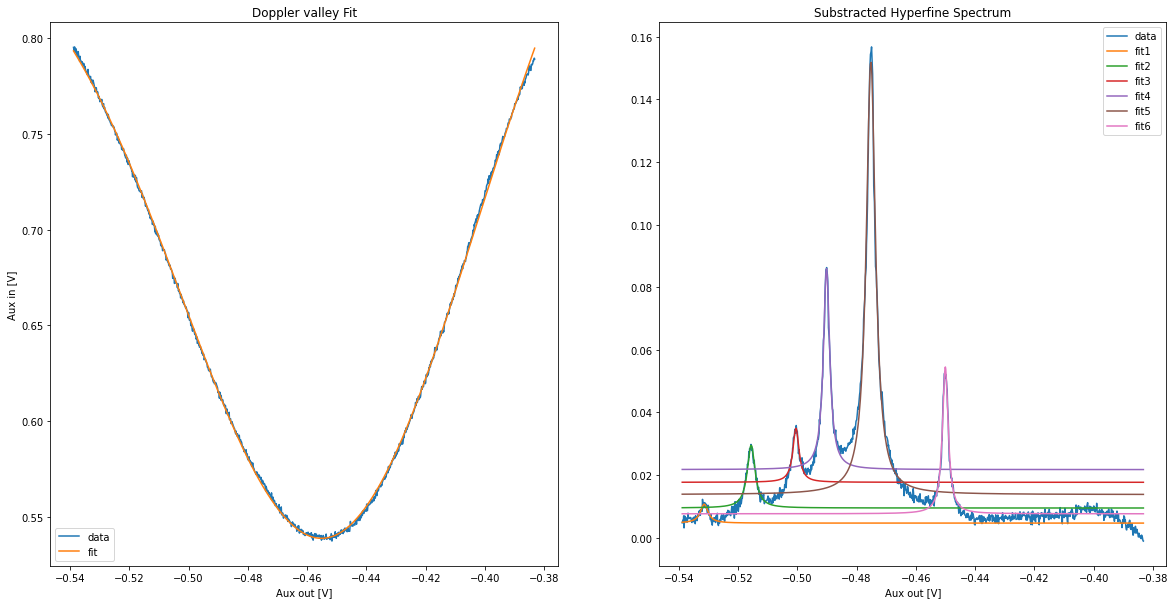

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data_substracted,label='data')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt1),label='fit1')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt2),label='fit2')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt3),label='fit3')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt4),label='fit4')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt5),label='fit5')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt6),label='fit6')

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
ax2.legend()

print("Gaussian:")
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}\n".format(popt[-2],perr[-2],popt[-1],perr[-1]))
print('Lorentzian 1:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask1],*popt1)-data_substracted[mask1])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt1[0],perr1[0],popt1[1],perr1[1],popt1[2],perr1[2],popt1[3],perr1[3]))
print('Lorentzian 2:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask2],*popt2)-data_substracted[mask2])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt2[0],perr2[0],popt2[1],perr2[1],popt2[2],perr2[2],popt2[3],perr2[3]))
print('Lorentzian 3:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask3],*popt3)-data_substracted[mask3])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt3[0],perr3[0],popt3[1],perr3[1],popt3[2],perr3[2],popt3[3],perr3[3]))
print('Lorentzian 4:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask4],*popt4)-data_substracted[mask4])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt4[0],perr4[0],popt4[1],perr4[1],popt4[2],perr4[2],popt4[3],perr4[3]))
print('Lorentzian 5:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask5],*popt5)-data_substracted[mask5])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt5[0],perr5[0],popt5[1],perr5[1],popt5[2],perr5[2],popt5[3],perr5[3]))
print('Lorentzian 6:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask6],*popt6)-data_substracted[mask6])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt6[0],perr6[0],popt6[1],perr6[1],popt6[2],perr6[2],popt6[3],perr6[3]))

In [38]:
print("Use F' 2\&3 crossover and F' 1\&3 crossover for calibration.")
delta_t = (popt5[1]-popt4[1])
delta_t_err = np.sqrt(perr5[1]**2+perr4[1]**2)
print("Difference: ({:f} +/- {:f}) V".format(delta_t,delta_t_err))
print("Literaturwert: 78.47 MHz")
K = 78.47/delta_t
K_err = 78.47/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) MHz/V".format(K,K_err))

Use F' 2\&3 crossover and F' 1\&3 crossover for calibration.
Difference: (0.014952 +/- 0.000021) V
Literaturwert: 78.47 MHz
Kalibrierungsfaktor K = (5247.989 +/- 7.423) MHz/V


In [39]:
print("Dopplerverbreiterung:")
sigma_V = popt[2]
sigma_V_err = perr[2]

sigma = K * sigma_V
sigma_err = np.sqrt((sigma_V*K_err)**2+(K*sigma_V_err)**2)

mean = 384.2304844685 * 1e6 - 2.563005979089109 *1e3 #MHz
mean_err = np.sqrt((0.0000000062 * 1e6)**2 + (0.000000000000034 * 1e3)**2) #MHz


T = (sigma/mean)**2 * m87*c**2/kB
T_err = np.sqrt((2*sigma/mean**2 * sigma_err)**2+(2*sigma**2/mean**3 * mean_err)**2) * m87*c**2/kB


print("Temperatur: ({:.1f} +/- {:.1f}) K".format(T,T_err))

print('\nNatürliche Linienbreite:')

gammaf1 = K * popt1[2]
gammaf2 = K * popt3[2]
gammaf3 = K * popt6[2]

gammaf1_err = np.sqrt((K*perr1[2])**2 + (popt1[1]*K_err)**2)
gammaf2_err = np.sqrt((K*perr3[2])**2 + (popt3[1]*K_err)**2)
gammaf3_err = np.sqrt((K*perr6[2])**2 + (popt6[1]*K_err)**2)

print('Theorie: 6.067 MHz')
print("87Rb F=2 -> F'=1: ({:.1f} +/- {:.1f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf1,gammaf1_err,(gammaf1-6.067)/6.067*100))
print("87Rb F=2 -> F'=2: ({:.1f} +/- {:.1f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf2,gammaf2_err,(gammaf2-6.067)/6.067*100))
print("87Rb F=2 -> F'=3: ({:.1f} +/- {:.1f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf3,gammaf3_err,(gammaf3-6.067)/6.067*100))


Dopplerverbreiterung:
Temperatur: (440.3 +/- 2.2) K

Natürliche Linienbreite:
Theorie: 6.067 MHz
87Rb F=2 -> F'=1: (16.7 +/- 4.6) MHz, rel. Abweichung: 174.50%
87Rb F=2 -> F'=2: (13.4 +/- 4.0) MHz, rel. Abweichung: 120.32%
87Rb F=2 -> F'=3: (12.3 +/- 3.4) MHz, rel. Abweichung: 102.42%


In [40]:
f1 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],48,49)
f2 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],149,150)
f3 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],245,246)
f4 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],313,314)
f5 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],409,410)
f6 = interpolate_zero_between(data['Aux out [V]'],data['PDH out [a.u.]'],568,569)
print('Fit vs. Zero Crossings: rel. Abweichungen (von links nach rechts):')
print('{:.2f} %'.format((f1-popt1[1])/f1*100))
print('{:.2f} %'.format((f2-popt2[1])/f1*100))
print('{:.2f} %'.format((f3-popt3[1])/f1*100))
print('{:.2f} %'.format((f4-popt4[1])/f1*100))
print('{:.2f} %'.format((f5-popt5[1])/f1*100))
print('{:.2f} %'.format((f6-popt6[1])/f1*100))

Fit vs. Zero Crossings: rel. Abweichungen (von links nach rechts):
-0.03 %
0.01 %
0.02 %
-0.01 %
-0.04 %
0.02 %


In [41]:
delta1 = (popt6[1]-popt3[1])
delta1_err = np.sqrt(perr6[1]**2+perr3[1]**2)
hyper_diff1 = K * delta1
hyper_diff1_err = np.sqrt((delta1*K_err)**2+(K*delta1_err)**2)

delta2 = (popt3[1]-popt1[1])
delta2_err = np.sqrt(perr3[1]**2+perr1[1]**2)
hyper_diff2 = K * delta2
hyper_diff2_err = np.sqrt((delta2*K_err)**2+(K*delta2_err)**2)

print("Hyperfeinaufspaltung 87Rb F'=3 - F'=2: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff1,hyper_diff1_err))
print('Theorie: 266.65 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff1-266.65)/266.65*100))
print("Hyperfeinaufspaltung 87Rb F'=2 - F'=1: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff2,hyper_diff2_err))
print('Theorie: 156.95 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff2-156.95)/156.95*100))

Hyperfeinaufspaltung 87Rb F'=3 - F'=2: (264.4 +/- 0.5) MHz
Theorie: 266.65 MHz, rel. Abweichung: -0.86 %
Hyperfeinaufspaltung 87Rb F'=2 - F'=1: (162.4 +/- 0.6) MHz
Theorie: 156.95 MHz, rel. Abweichung: 3.47 %


## 85 Rb F=3 --> F'

Text(0.5, 1.0, 'Repump off')

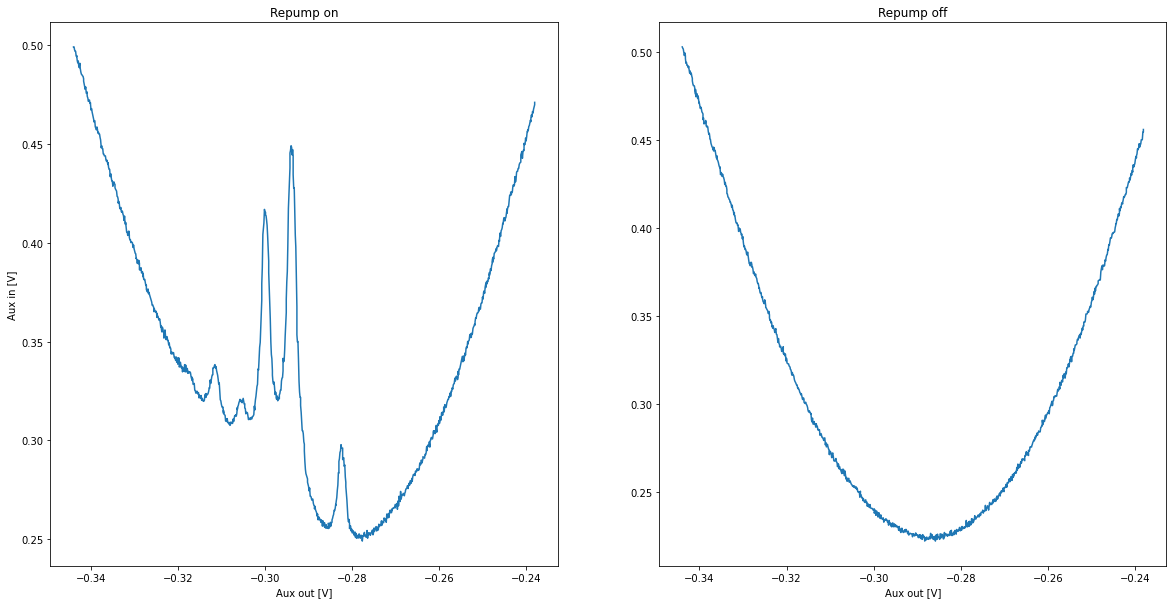

In [42]:
transition = "85_3"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [43]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,-0.4,0,0,-1],[1,-0.2,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))
data_substracted = data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt)

In [44]:
mask1 = set_mask(data['Aux out [V]'],-0.319,-0.3155)
popt1, pcov1 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask1],data_substracted[mask1],bounds=([0,-0.32,0,0],[1,-0.3155,0.5,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],-0.314,-0.309)
popt2, pcov2 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask2],data_substracted[mask2],bounds=([0,-0.314,0,0],[1,-0.309,0.5,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],-0.307,-0.304)
popt3, pcov3 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask3],data_substracted[mask3],bounds=([0,-0.307,0,0],[1,-0.304,0.5,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],-0.302,-0.298)
popt4, pcov4 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask4],data_substracted[mask4],bounds=([0,-0.302,0,0],[1,-0.298,0.5,1]))
perr4 = np.sqrt(np.diag(pcov4))

mask5 = set_mask(data['Aux out [V]'],-0.296,-0.292)
popt5, pcov5 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask5],data_substracted[mask5],bounds=([0,-0.296,0,0],[1,-0.292,0.5,1]))
perr5 = np.sqrt(np.diag(pcov5))

mask6 = set_mask(data['Aux out [V]'],-0.285,-0.28)
popt6, pcov6 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask6],data_substracted[mask6],bounds=([0,-0.285,0,0],[1,-0.28,0.5,1]))
perr6 = np.sqrt(np.diag(pcov6))

Gaussian:
res = 0.044464
A = 0.32383 +/- 0.011269, mean = -0.28231 +/- 0.000258 ,std = 0.08615 +/- 0.001044
offset = 2.00000 +/- 0.045624, slope = 0.97320 +/- 0.047922

Lorentzian 1: (not trusty)
res = 0.006778
A = 0.02410 +/- 0.026558, mean = -0.31676 +/- 0.000091 ,gamma = 0.00689 +/- 0.004963, offset = 0.00000 +/- 0.026769

Lorentzian 2: (not trusty)
res = 0.014167
A = 0.03933 +/- 0.003910, mean = -0.31115 +/- 0.000032 ,gamma = 0.00398 +/- 0.000455, offset = 0.01695 +/- 0.004186

Lorentzian 3: (not trusty)
res = 0.005505
A = 0.06355 +/- 0.036446, mean = -0.30499 +/- 0.000043 ,gamma = 0.00694 +/- 0.002537, offset = 0.00144 +/- 0.036655

Lorentzian 4:
res = 0.021737
A = 0.14043 +/- 0.005249, mean = -0.29985 +/- 0.000012 ,gamma = 0.00264 +/- 0.000134, offset = 0.03879 +/- 0.005735

Lorentzian 5:
res = 0.033108
A = 0.18296 +/- 0.008184, mean = -0.29390 +/- 0.000014 ,gamma = 0.00266 +/- 0.000163, offset = 0.04179 +/- 0.008973

Lorentzian 6:
res = 0.021211
A = 0.05210 +/- 0.002224, mean = 

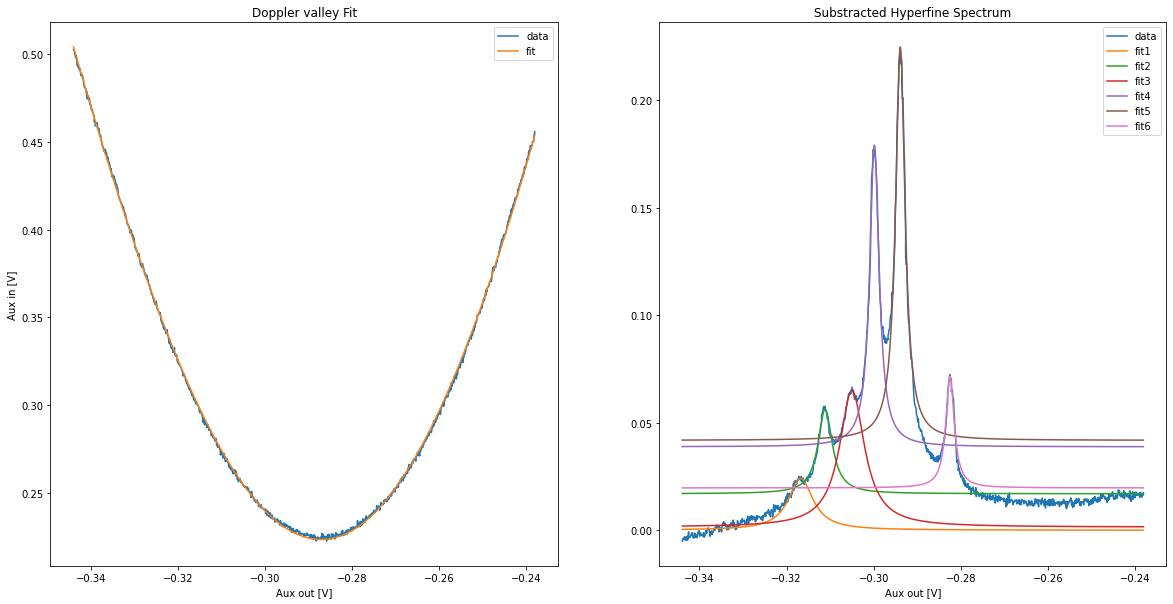

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data_substracted,label='data')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt1),label='fit1')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt2),label='fit2')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt3),label='fit3')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt4),label='fit4')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt5),label='fit5')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt6),label='fit6')

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
ax2.legend()

print("Gaussian:")
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}\n".format(popt[-2],perr[-2],popt[-1],perr[-1]))
print('Lorentzian 1: (not trusty)')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask1],*popt1)-data_substracted[mask1])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt1[0],perr1[0],popt1[1],perr1[1],popt1[2],perr1[2],popt1[3],perr1[3]))
print('Lorentzian 2: (not trusty)')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask2],*popt2)-data_substracted[mask2])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt2[0],perr2[0],popt2[1],perr2[1],popt2[2],perr2[2],popt2[3],perr2[3]))
print('Lorentzian 3: (not trusty)')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask3],*popt3)-data_substracted[mask3])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt3[0],perr3[0],popt3[1],perr3[1],popt3[2],perr3[2],popt3[3],perr3[3]))
print('Lorentzian 4:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask4],*popt4)-data_substracted[mask4])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt4[0],perr4[0],popt4[1],perr4[1],popt4[2],perr4[2],popt4[3],perr4[3]))
print('Lorentzian 5:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask5],*popt5)-data_substracted[mask5])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt5[0],perr5[0],popt5[1],perr5[1],popt5[2],perr5[2],popt5[3],perr5[3]))
print('Lorentzian 6:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask6],*popt6)-data_substracted[mask6])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt6[0],perr6[0],popt6[1],perr6[1],popt6[2],perr6[2],popt6[3],perr6[3]))

In [46]:
print("Use F' 2&4 crossover and F' 3&4 crossover for calibration.")
delta_t = (popt5[1]-popt4[1])
delta_t_err = np.sqrt(perr5[1]**2+perr4[1]**2)
print("Difference: ({:f} +/- {:f}) V".format(delta_t,delta_t_err))
print("Literaturwert: 31.7 MHz")
K = 31.7/delta_t
K_err = 31.7/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) MHz/V".format(K,K_err))

Use F' 2&4 crossover and F' 3&4 crossover for calibration.
Difference: (0.005943 +/- 0.000018) V
Literaturwert: 31.7 MHz
Kalibrierungsfaktor K = (5333.784 +/- 16.408) MHz/V


In [47]:
print("Dopplerverbreiterung:")
sigma_V = popt[2]
sigma_V_err = perr[2]

sigma = K * sigma_V
sigma_err = np.sqrt((sigma_V*K_err)**2+(K*sigma_V_err)**2)

mean = 384.230406373 * 1e6 - 1.2648885163 *1e3 #MHz
mean_err = np.sqrt((0.000000014 * 1e6)**2 + (0.000000000025 * 1e3)**2) #MHz

T = (sigma/mean)**2 * m85*c**2/kB
T_err = np.sqrt((2*sigma/mean**2 * sigma_err)**2+(2*sigma**2/mean**3 * mean_err)**2) * m85*c**2/kB


print("Temperatur: ({:.4f} +/- {:.4f}) K".format(T,T_err))

print('\nNatürliche Linienbreite:')

gammaf1 = K * popt1[2]
gammaf2 = K * popt3[2]
gammaf3 = K * popt6[2]

gammaf1_err = np.sqrt((K*perr1[2])**2 + (popt1[1]*K_err)**2)
gammaf2_err = np.sqrt((K*perr3[2])**2 + (popt3[1]*K_err)**2)
gammaf3_err = np.sqrt((K*perr6[2])**2 + (popt6[1]*K_err)**2)

print('Theorie: 6.067 MHz')
print("85Rb F=3 -> F'=2: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf1,gammaf1_err,(gammaf1-6.067)/6.067*100))
print("85Rb F=3 -> F'=3: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf2,gammaf2_err,(gammaf2-6.067)/6.067*100))
print("85Rb F=3 -> F'=4: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf3,gammaf3_err,(gammaf3-6.067)/6.067*100))


Dopplerverbreiterung:
Temperatur: (1312.6820 +/- 32.8240) K

Natürliche Linienbreite:
Theorie: 6.067 MHz
85Rb F=3 -> F'=2: (36.7250 +/- 26.9774) MHz, rel. Abweichung: 505.32%
85Rb F=3 -> F'=3: (37.0351 +/- 14.4285) MHz, rel. Abweichung: 510.44%
85Rb F=3 -> F'=4: (12.4116 +/- 4.7446) MHz, rel. Abweichung: 104.57%


In [48]:
delta1 = (popt6[1]-popt3[1])
delta1_err = np.sqrt(perr6[1]**2+perr3[1]**2)
hyper_diff1 = K * delta1
hyper_diff1_err = np.sqrt((delta1*K_err)**2+(K*delta1_err)**2)

delta2 = (popt3[1]-popt1[1])
delta2_err = np.sqrt(perr3[1]**2+perr1[1]**2)
hyper_diff2 = K * delta2
hyper_diff2_err = np.sqrt((delta2*K_err)**2+(K*delta2_err)**2)

print("Hyperfeinaufspaltung 85Rb F'=4 - F'=3: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff1,hyper_diff1_err))
print('Theorie: 120.64 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff1-120.64)/120.64*100))
print("Hyperfeinaufspaltung 85Rb F'=3 - F'=2: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff2,hyper_diff2_err))
print('Theorie: 63.40 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff2-63.40)/63.40*100))

Hyperfeinaufspaltung 85Rb F'=4 - F'=3: (120.0 +/- 0.5) MHz
Theorie: 120.64 MHz, rel. Abweichung: -0.54 %
Hyperfeinaufspaltung 85Rb F'=3 - F'=2: (62.8 +/- 0.6) MHz
Theorie: 63.40 MHz, rel. Abweichung: -0.97 %


## 85 Rb F=2 --> F'

Text(0.5, 1.0, 'Repump off')

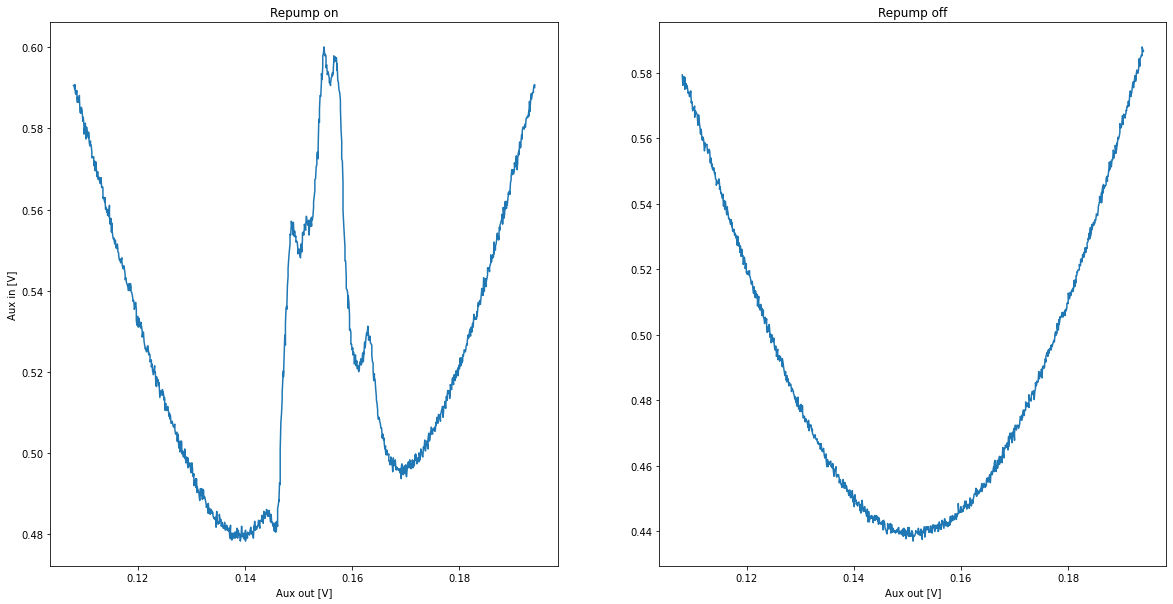

In [49]:
transition = "85_2"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [50]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0.1,0,0,-1],[1,0.2,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))
data_substracted = data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt)

In [51]:
mask1 = set_mask(data['Aux out [V]'],0.146,0.15)
popt1, pcov1 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask1],data_substracted[mask1],bounds=([0,0.146,0,0],[1,0.15,0.5,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],0.153,0.156)
popt2, pcov2 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask2],data_substracted[mask2],bounds=([0,0.153,0,0],[1,0.156,0.5,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],0.156,0.158)
popt3, pcov3 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask3],data_substracted[mask3],bounds=([0,0.156,0,0],[1,0.158,0.5,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],0.162,0.165)
popt4, pcov4 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask4],data_substracted[mask4],bounds=([0,0.162,0,0],[1,0.165,0.5,1]))
perr4 = np.sqrt(np.diag(pcov4))

Gaussian:
res = 0.033636
A = 0.07546 +/- 0.002037, mean = 0.15357 +/- 0.000118 ,std = 0.05480 +/- 0.000537
offset = 0.92522 +/- 0.008682, slope = 0.41386 +/- 0.018219

Lorentzian 1:
res = 0.026691
A = 0.11932 +/- 0.010134, mean = 0.14900 +/- 0.000040 ,gamma = 0.00490 +/- 0.000470, offset = 0.00000 +/- 0.010674

Lorentzian 2:
res = 0.012361
A = 0.08351 +/- 0.019217, mean = 0.15499 +/- 0.000030 ,gamma = 0.00496 +/- 0.000866, offset = 0.07437 +/- 0.019562

Lorentzian 3:
res = 0.005496
A = 0.15539 +/- 0.287660, mean = 0.15674 +/- 0.000030 ,gamma = 0.00683 +/- 0.006965, offset = 0.00000 +/- 0.287954

Lorentzian 4:
res = 0.005546
A = 0.05793 +/- 0.006457, mean = 0.16280 +/- 0.000026 ,gamma = 0.00476 +/- 0.000465, offset = 0.02046 +/- 0.006618



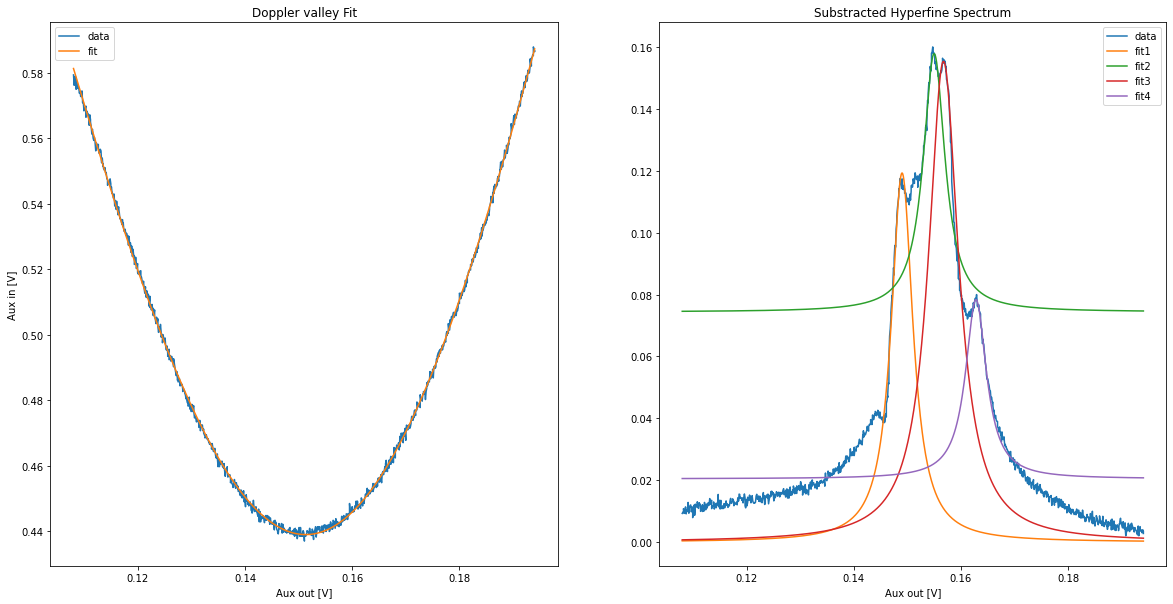

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data_substracted,label='data')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt1),label='fit1')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt2),label='fit2')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt3),label='fit3')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt4),label='fit4')

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
ax2.legend()

print("Gaussian:")
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}\n".format(popt[-2],perr[-2],popt[-1],perr[-1]))
print('Lorentzian 1:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask1],*popt1)-data_substracted[mask1])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt1[0],perr1[0],popt1[1],perr1[1],popt1[2],perr1[2],popt1[3],perr1[3]))
print('Lorentzian 2:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask2],*popt2)-data_substracted[mask2])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt2[0],perr2[0],popt2[1],perr2[1],popt2[2],perr2[2],popt2[3],perr2[3]))
print('Lorentzian 3:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask3],*popt3)-data_substracted[mask3])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt3[0],perr3[0],popt3[1],perr3[1],popt3[2],perr3[2],popt3[3],perr3[3]))
print('Lorentzian 4:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask4],*popt4)-data_substracted[mask4])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt4[0],perr4[0],popt4[1],perr4[1],popt4[2],perr4[2],popt4[3],perr4[3]))

In [53]:
print("Use F' 2&3 crossover and F' 1&3 crossover for calibration.")
delta_t = (popt3[1]-popt2[1])
delta_t_err = np.sqrt(perr3[1]**2+perr2[1]**2)
print("Difference: ({:f} +/- {:f}) V".format(delta_t,delta_t_err))
print("Literaturwert: 14.65 MHz")
K = 14.65/delta_t
K_err = 14.65/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) MHz/V".format(K,K_err))

Use F' 2&3 crossover and F' 1&3 crossover for calibration.
Difference: (0.001746 +/- 0.000042) V
Literaturwert: 14.65 MHz
Kalibrierungsfaktor K = (8392.646 +/- 202.450) MHz/V


In [54]:
print("Dopplerverbreiterung:")
sigma_V = popt[2]
sigma_V_err = perr[2]

sigma = K * sigma_V
sigma_err = np.sqrt((sigma_V*K_err)**2+(K*sigma_V_err)**2)

mean = 384.230406373 * 1e6 + 1.7708439228 *1e3 #MHz
mean_err = np.sqrt((0.000000014 * 1e6)**2 + (0.0000000035 * 1e3)**2) #MHz

T = (sigma/mean)**2 * m85*c**2/kB
T_err = np.sqrt((2*sigma/mean**2 * sigma_err)**2+(2*sigma**2/mean**3 * mean_err)**2) * m85*c**2/kB


print("Temperatur: ({:.4f} +/- {:.4f}) K".format(T,T_err))

print('\nNatürliche Linienbreite:')

gammaf3 = K * popt4[2]

gammaf3_err = np.sqrt((K*perr4[2])**2 + (popt4[1]*K_err)**2)

print('Theorie: 6.067 MHz')
print("85Rb F=2 -> F'=3: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf3,gammaf3_err,(gammaf3-6.067)/6.067*100))


Dopplerverbreiterung:
Temperatur: (1315.1592 +/- 68.4855) K

Natürliche Linienbreite:
Theorie: 6.067 MHz
85Rb F=2 -> F'=3: (39.9569 +/- 33.1886) MHz, rel. Abweichung: 558.59%


In [55]:
delta1 = (popt4[1]-popt3[1])*2 #Use crossover as proxy
delta1_err = np.sqrt(perr4[1]**2+perr3[1]**2)*2
hyper_diff1 = K * delta1
hyper_diff1_err = np.sqrt((delta1*K_err)**2+(K*delta1_err)**2)

delta2 = (popt4[1]-popt2[1])*2-delta1 #Use crossover as proxy
delta2_err = np.sqrt(4*perr4[1]**2+4*perr2[1]**2+delta1_err**2)
hyper_diff2 = K * delta2
hyper_diff2_err = np.sqrt((delta2*K_err)**2+(K*delta2_err)**2)

print("Hyperfeinaufspaltung 85Rb F'=3 - F'=2: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff1,hyper_diff1_err))
print('Theorie: 63.40 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff1-63.40)/63.40*100))
print("(proxy) Hyperfeinaufspaltung 85Rb F'=2 - F'=1: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff2,hyper_diff2_err))
print('Theorie: 29.37 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff2-29.37)/29.37*100))

Hyperfeinaufspaltung 85Rb F'=3 - F'=2: (101.7 +/- 2.5) MHz
Theorie: 63.40 MHz, rel. Abweichung: 60.49 %
(proxy) Hyperfeinaufspaltung 85Rb F'=2 - F'=1: (29.3 +/- 1.2) MHz
Theorie: 29.37 MHz, rel. Abweichung: -0.24 %


## 87 Rb F=1 --> F'

Text(0.5, 1.0, 'Repump off')

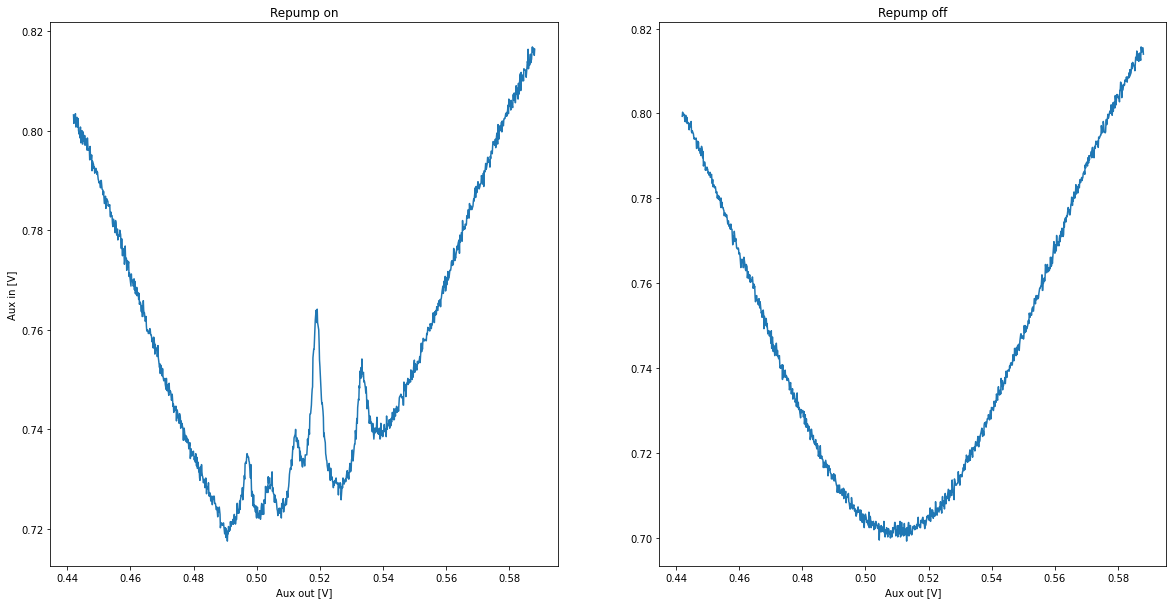

In [56]:
transition = "87_1"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [57]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0.4,0,0,-1],[1,0.6,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))
data_substracted = data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt)

In [58]:
mask1 = set_mask(data['Aux out [V]'],0.492,0.5)
popt1, pcov1 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask1],data_substracted[mask1],bounds=([0,0.492,0,0],[1,0.5,0.5,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],0.502,0.507)
popt2, pcov2 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask2],data_substracted[mask2],bounds=([0,0.502,0,0],[1,0.507,0.5,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],0.51,0.514)
popt3, pcov3 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask3],data_substracted[mask3],bounds=([0,0.51,0,0],[1,0.514,0.5,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],0.515,0.526)
popt4, pcov4 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask4],data_substracted[mask4],bounds=([0,0.515,0,0],[1,0.525,0.5,1]))
perr4 = np.sqrt(np.diag(pcov4))

mask5 = set_mask(data['Aux out [V]'],0.528,0.538)
popt5, pcov5 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask5],data_substracted[mask5],bounds=([0,0.528,0,0],[1,0.538,0.5,1]))
perr5 = np.sqrt(np.diag(pcov5))

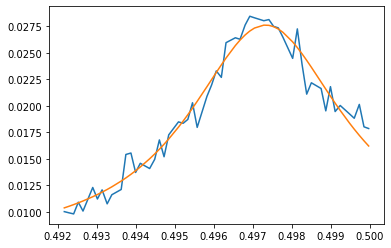

In [59]:
mask = set_mask(data['Aux out [V]'],0.492,0.5)
poptt, pcovt = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask],data_substracted[mask],bounds=([0,0.492,0,0],[1,0.5,0.5,1]))
plt.plot(data['Aux out [V]'][mask],data_substracted[mask])
plt.plot(data['Aux out [V]'][mask],shifted_lorentzian(data['Aux out [V]'][mask],*poptt))

Gaussian:
res = 0.029942
A = 0.01800 +/- 0.000123, mean = 0.50950 +/- 0.000065 ,std = 0.04682 +/- 0.000146
offset = 0.86096 +/- 0.001687, slope = -0.01291 +/- 0.002548

Lorentzian 1:
res = 0.008664
A = 0.02112 +/- 0.000843, mean = 0.49732 +/- 0.000043 ,gamma = 0.00487 +/- 0.000324, offset = 0.00651 +/- 0.000915

Lorentzian 2:
res = 0.005812
A = 0.01268 +/- 0.005378, mean = 0.50438 +/- 0.000070 ,gamma = 0.00518 +/- 0.001931, offset = 0.01473 +/- 0.005570

Lorentzian 3:
res = 0.004094
A = 0.02019 +/- 0.005768, mean = 0.51241 +/- 0.000045 ,gamma = 0.00502 +/- 0.001166, offset = 0.01716 +/- 0.005921

Lorentzian 4:
res = 0.014582
A = 0.04229 +/- 0.000684, mean = 0.51880 +/- 0.000027 ,gamma = 0.00437 +/- 0.000144, offset = 0.01584 +/- 0.000634

Lorentzian 5:
res = 0.011983
A = 0.01982 +/- 0.000658, mean = 0.53318 +/- 0.000044 ,gamma = 0.00357 +/- 0.000254, offset = 0.01316 +/- 0.000637



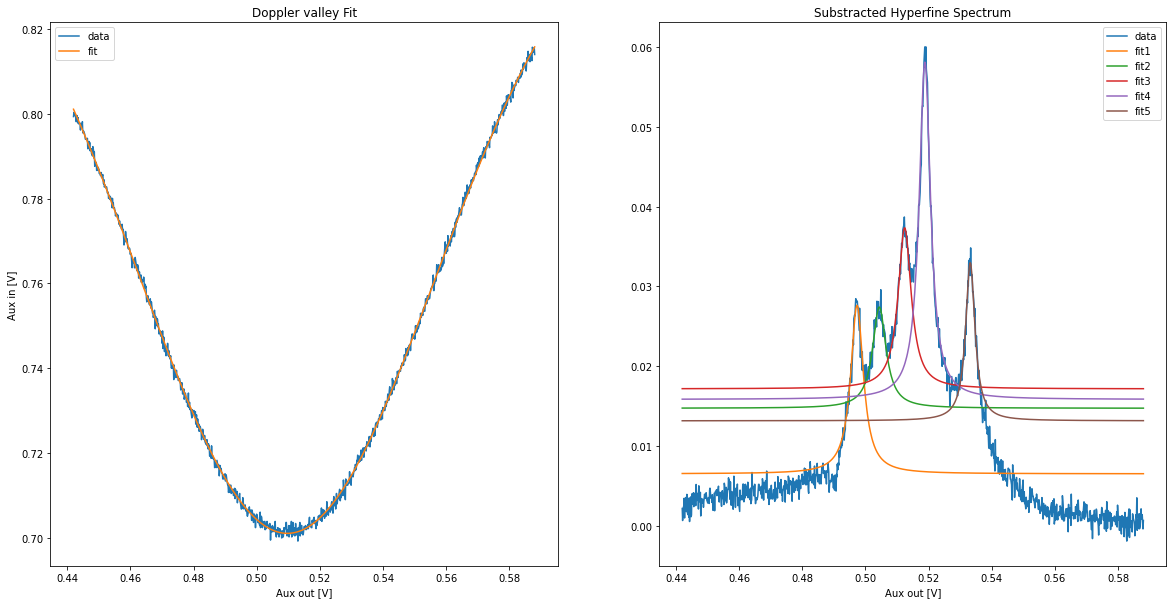

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data_substracted,label='data')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt1),label='fit1')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt2),label='fit2')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt3),label='fit3')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt4),label='fit4')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt5),label='fit5')

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
ax2.legend()

print("Gaussian:")
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}\n".format(popt[-2],perr[-2],popt[-1],perr[-1]))
print('Lorentzian 1:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask1],*popt1)-data_substracted[mask1])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt1[0],perr1[0],popt1[1],perr1[1],popt1[2],perr1[2],popt1[3],perr1[3]))
print('Lorentzian 2:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask2],*popt2)-data_substracted[mask2])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt2[0],perr2[0],popt2[1],perr2[1],popt2[2],perr2[2],popt2[3],perr2[3]))
print('Lorentzian 3:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask3],*popt3)-data_substracted[mask3])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt3[0],perr3[0],popt3[1],perr3[1],popt3[2],perr3[2],popt3[3],perr3[3]))
print('Lorentzian 4:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask4],*popt4)-data_substracted[mask4])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt4[0],perr4[0],popt4[1],perr4[1],popt4[2],perr4[2],popt4[3],perr4[3]))
print('Lorentzian 5:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask5],*popt5)-data_substracted[mask5])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt5[0],perr5[0],popt5[1],perr5[1],popt5[2],perr5[2],popt5[3],perr5[3]))

In [61]:
print("Use F' 0&2 crossover and F' 1&2 crossover for calibration.")
delta_t = (popt4[1]-popt3[1])
delta_t_err = np.sqrt(perr4[1]**2+perr3[1]**2)
print("Difference: ({:f} +/- {:f}) V".format(delta_t,delta_t_err))
print("Literaturwert: 36.105 MHz")
K = 36.105/delta_t
K_err = 36.105/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) MHz/V".format(K,K_err))

Use F' 0&2 crossover and F' 1&2 crossover for calibration.
Difference: (0.006397 +/- 0.000052) V
Literaturwert: 36.105 MHz
Kalibrierungsfaktor K = (5644.184 +/- 45.901) MHz/V


In [62]:
print("Dopplerverbreiterung:")
sigma_V = popt[2]
sigma_V_err = perr[2]

sigma = K * sigma_V
sigma_err = np.sqrt((sigma_V*K_err)**2+(K*sigma_V_err)**2)

mean = 384.2304844685 * 1e6 + 4.271676631815181 *1e3 #MHz
mean_err = np.sqrt((0.0000000062 * 1e6)**2 + (0.000000000000056 * 1e3)**2) #MHz


T = (sigma/mean)**2 * m85*c**2/kB
T_err = np.sqrt((2*sigma/mean**2 * sigma_err)**2+(2*sigma**2/mean**3 * mean_err)**2) * m85*c**2/kB


print("Temperatur: ({:.4f} +/- {:.4f}) K".format(T,T_err))

print('\nNatürliche Linienbreite:')

gammaf1 = K * popt2[2]
gammaf2 = K * popt5[2]

gammaf1_err = np.sqrt((K*perr2[2])**2 + (popt2[1]*K_err)**2)
gammaf2_err = np.sqrt((K*perr5[2])**2 + (popt5[1]*K_err)**2)

print('Theorie: 6.067 MHz')
print("87Rb F=1 -> F'=1: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf1,gammaf1_err,(gammaf1-6.067)/6.067*100))
print("87Rb F=1 -> F'=2: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf2,gammaf2_err,(gammaf2-6.067)/6.067*100))

Dopplerverbreiterung:
Temperatur: (434.1619 +/- 7.5615) K

Natürliche Linienbreite:
Theorie: 6.067 MHz
87Rb F=1 -> F'=1: (29.2165 +/- 25.5876) MHz, rel. Abweichung: 381.56%
87Rb F=1 -> F'=2: (20.1454 +/- 24.5153) MHz, rel. Abweichung: 232.05%


In [63]:
delta1 = (popt5[1]-popt2[1])
delta1_err = np.sqrt(perr5[1]**2+perr2[1]**2)
hyper_diff1 = K * delta1
hyper_diff1_err = np.sqrt((delta1*K_err)**2+(K*delta1_err)**2)

delta2 = (popt2[1]-popt1[1])*2 #Use crossover as proxy
delta2_err = np.sqrt(perr2[1]**2+perr1[1]**2)*2
hyper_diff2 = K * delta2
hyper_diff2_err = np.sqrt((delta2*K_err)**2+(K*delta2_err)**2)

print("Hyperfeinaufspaltung 87Rb F'=2 - F'=1: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff1,hyper_diff1_err))
print('Theorie: 156.95 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff1-156.95)/156.95*100))
print("(proxy) Hyperfeinaufspaltung 87Rb F'=1 - F'=0: ({:.1f} +/- {:.1f}) MHz".format(hyper_diff2,hyper_diff2_err))
print('Theorie: 72.22 MHz, rel. Abweichung: {:.2f} %'.format((hyper_diff2-72.22)/72.22*100))


Hyperfeinaufspaltung 87Rb F'=2 - F'=1: (162.5 +/- 1.4) MHz
Theorie: 156.95 MHz, rel. Abweichung: 3.56 %
(proxy) Hyperfeinaufspaltung 87Rb F'=1 - F'=0: (79.6 +/- 1.1) MHz
Theorie: 72.22 MHz, rel. Abweichung: 10.26 %
